# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [5]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_1189396/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1189396/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1189396/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [6]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [7]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [8]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [ ]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4003, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 2/1000 [00:00<03:01,  5.49it/s]

tensor(1.3896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, grad_fn=<Mean

  0%|          | 3/1000 [00:00<02:40,  6.23it/s]

current_loss: tensor(158.5992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.416

  0%|          | 5/1000 [00:00<02:26,  6.77it/s]

current_loss: tensor(1.4149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4127,

  1%|          | 6/1000 [00:00<02:25,  6.84it/s]

current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4352,

  1%|          | 8/1000 [00:01<02:15,  7.34it/s]

current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4731,

  1%|          | 9/1000 [00:01<02:17,  7.22it/s]

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<35:53, 10.82s/it]

[1/200] train=20381.8630  val_ELPD=-1.4664  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.18  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600833  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03μ-nudge(±)≈0.847


  1%|          | 2/200 [00:21<34:53, 10.57s/it]

[2/200] train=71.6223  val_ELPD=-1.4733  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.22  priors/obs: decor≈0 trans≈23.5  tau4=0.619226  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈22.2  target≈22.2  resid≈0.33  Δ=+1.84e-02μ-nudge(±)≈1.31


  2%|▏         | 3/200 [00:31<34:28, 10.50s/it]

[3/200] train=71.9785  val_ELPD=-1.4832  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.32  priors/obs: decor≈0 trans≈23  tau4=0.634981  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈22.2  target≈22.2  resid≈0.275  Δ=+1.58e-02μ-nudge(±)≈0.609


  2%|▏         | 4/200 [00:42<34:13, 10.48s/it]

[4/200] train=71.3531  val_ELPD=-1.4838  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.4  priors/obs: decor≈0 trans≈22.5  tau4=0.636588  rank=20  E_qf_mean≈17  E_qf_total≈34.1  tau*E_qf≈21.7  target≈22.2  resid≈0.274  Δ=+1.61e-03μ-nudge(±)≈0.267


  2%|▎         | 5/200 [00:52<33:56, 10.44s/it]

[5/200] train=70.2843  val_ELPD=-1.4784  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.36  priors/obs: decor≈0 trans≈21.9  tau4=0.639777  rank=20  E_qf_mean≈16.6  E_qf_total≈33.2  tau*E_qf≈21.2  target≈22.2  resid≈0.53  Δ=+3.19e-03μ-nudge(±)≈0.653


  3%|▎         | 6/200 [01:02<33:41, 10.42s/it]

[6/200] train=69.3735  val_ELPD=-1.4774  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.31  priors/obs: decor≈0 trans≈21.2  tau4=0.644476  rank=20  E_qf_mean≈16.2  E_qf_total≈32.3  tau*E_qf≈20.8  target≈22.2  resid≈0.76  Δ=+4.70e-03μ-nudge(±)≈-0.569


  4%|▎         | 7/200 [01:13<33:31, 10.42s/it]

[7/200] train=68.9634  val_ELPD=-1.4787  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0505 σmin=0.0500 σmax=0.0506  N=2000 B=200 B̄≈285.7  lik/obs≈10.31  priors/obs: decor≈0 trans≈20.6  tau4=0.650571  rank=20  E_qf_mean≈15.7  E_qf_total≈31.5  tau*E_qf≈20.5  target≈22.2  resid≈0.959  Δ=+6.09e-03μ-nudge(±)≈0.376


  4%|▍         | 8/200 [01:23<33:18, 10.41s/it]

[8/200] train=68.2279  val_ELPD=-1.4799  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0509 σmin=0.0504 σmax=0.0510  N=2000 B=200 B̄≈285.7  lik/obs≈10.33  priors/obs: decor≈0 trans≈19.9  tau4=0.66527  rank=20  E_qf_mean≈15.3  E_qf_total≈30.7  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.47e-02μ-nudge(±)≈0.99


  4%|▍         | 9/200 [01:34<33:08, 10.41s/it]

[9/200] train=67.2695  val_ELPD=-1.4790  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0513 σmin=0.0507 σmax=0.0513  N=2000 B=200 B̄≈285.7  lik/obs≈10.34  priors/obs: decor≈0 trans≈19.4  tau4=0.680874  rank=20  E_qf_mean≈14.9  E_qf_total≈29.9  tau*E_qf≈20.3  target≈22.2  resid≈1.17  Δ=+1.56e-02μ-nudge(±)≈1.04


  5%|▌         | 10/200 [01:44<32:58, 10.41s/it]

[10/200] train=67.0028  val_ELPD=-1.4787  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0516 σmin=0.0511 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈10.32  priors/obs: decor≈0 trans≈18.9  tau4=0.697401  rank=20  E_qf_mean≈14.5  E_qf_total≈29.1  tau*E_qf≈20.3  target≈22.2  resid≈1.2  Δ=+1.65e-02μ-nudge(±)≈0.643


  6%|▌         | 11/200 [01:54<32:48, 10.41s/it]

[11/200] train=66.1119  val_ELPD=-1.4789  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0519 σmin=0.0514 σmax=0.0520  N=2000 B=200 B̄≈285.7  lik/obs≈10.32  priors/obs: decor≈0 trans≈18.5  tau4=0.714308  rank=20  E_qf_mean≈14.2  E_qf_total≈28.4  tau*E_qf≈20.3  target≈22.2  resid≈1.2  Δ=+1.69e-02μ-nudge(±)≈-0.102


  6%|▌         | 12/200 [02:05<32:35, 10.40s/it]

[12/200] train=65.5171  val_ELPD=-1.4794  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0522 σmin=0.0516 σmax=0.0523  N=2000 B=200 B̄≈285.7  lik/obs≈10.32  priors/obs: decor≈0 trans≈18.2  tau4=0.730932  rank=20  E_qf_mean≈13.9  E_qf_total≈27.8  tau*E_qf≈20.3  target≈22.2  resid≈1.16  Δ=+1.66e-02μ-nudge(±)≈1.15


  6%|▋         | 13/200 [02:15<32:26, 10.41s/it]

[13/200] train=64.9402  val_ELPD=-1.4803  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0524 σmin=0.0519 σmax=0.0525  N=2000 B=200 B̄≈285.7  lik/obs≈10.33  priors/obs: decor≈0 trans≈17.8  tau4=0.747481  rank=20  E_qf_mean≈13.6  E_qf_total≈27.3  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.65e-02μ-nudge(±)≈-2.8


  7%|▋         | 14/200 [02:26<32:15, 10.41s/it]

[14/200] train=64.2842  val_ELPD=-1.4814  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0527 σmin=0.0522 σmax=0.0528  N=2000 B=200 B̄≈285.7  lik/obs≈10.34  priors/obs: decor≈0 trans≈17.5  tau4=0.764126  rank=20  E_qf_mean≈13.4  E_qf_total≈26.7  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.66e-02μ-nudge(±)≈1.16


  8%|▊         | 15/200 [02:36<32:05, 10.41s/it]

[15/200] train=63.4350  val_ELPD=-1.4822  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0530 σmin=0.0524 σmax=0.0530  N=2000 B=200 B̄≈285.7  lik/obs≈10.35  priors/obs: decor≈0 trans≈17.1  tau4=0.781006  rank=20  E_qf_mean≈13.1  E_qf_total≈26.2  tau*E_qf≈20.4  target≈22.2  resid≈1.1  Δ=+1.69e-02μ-nudge(±)≈-0.0455


  8%|▊         | 16/200 [02:46<31:55, 10.41s/it]

[16/200] train=63.5713  val_ELPD=-1.4827  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0532 σmin=0.0527 σmax=0.0533  N=2000 B=200 B̄≈285.7  lik/obs≈10.36  priors/obs: decor≈0 trans≈16.7  tau4=0.798248  rank=20  E_qf_mean≈12.8  E_qf_total≈25.6  tau*E_qf≈20.4  target≈22.2  resid≈1.1  Δ=+1.72e-02μ-nudge(±)≈2.58


  8%|▊         | 17/200 [02:57<31:55, 10.47s/it]

[17/200] train=63.5066  val_ELPD=-1.4829  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0535 σmin=0.0529 σmax=0.0536  N=2000 B=200 B̄≈285.7  lik/obs≈10.35  priors/obs: decor≈0 trans≈16.3  tau4=0.815924  rank=20  E_qf_mean≈12.5  E_qf_total≈25  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.77e-02μ-nudge(±)≈-0.946


  9%|▉         | 18/200 [03:07<31:43, 10.46s/it]

[18/200] train=62.8108  val_ELPD=-1.4848  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0537 σmin=0.0532 σmax=0.0538  N=2000 B=200 B̄≈285.7  lik/obs≈10.37  priors/obs: decor≈0 trans≈15.9  tau4=0.834123  rank=20  E_qf_mean≈12.2  E_qf_total≈24.5  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.82e-02μ-nudge(±)≈-1.34


 10%|▉         | 19/200 [03:18<31:33, 10.46s/it]

[19/200] train=61.9228  val_ELPD=-1.4857  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0540 σmin=0.0535 σmax=0.0541  N=2000 B=200 B̄≈285.7  lik/obs≈10.38  priors/obs: decor≈0 trans≈15.5  tau4=0.852904  rank=20  E_qf_mean≈12  E_qf_total≈23.9  tau*E_qf≈20.4  target≈22.2  resid≈1.12  Δ=+1.88e-02μ-nudge(±)≈0.782


 10%|█         | 20/200 [03:28<31:22, 10.46s/it]

[20/200] train=61.3405  val_ELPD=-1.4876  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0543 σmin=0.0537 σmax=0.0544  N=2000 B=200 B̄≈285.7  lik/obs≈10.39  priors/obs: decor≈0 trans≈15  tau4=0.87232  rank=20  E_qf_mean≈11.7  E_qf_total≈23.4  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.94e-02μ-nudge(±)≈-1.61


 10%|█         | 21/200 [03:39<31:11, 10.45s/it]

[21/200] train=61.4637  val_ELPD=-1.4891  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0544 σmin=0.0539 σmax=0.0545  N=2000 B=200 B̄≈285.7  lik/obs≈10.39  priors/obs: decor≈0 trans≈14.7  tau4=0.891852  rank=20  E_qf_mean≈11.4  E_qf_total≈22.9  tau*E_qf≈20.4  target≈22.2  resid≈1.12  Δ=+1.95e-02μ-nudge(±)≈-1.03


 11%|█         | 22/200 [03:49<30:59, 10.45s/it]

[22/200] train=60.4108  val_ELPD=-1.4895  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0546 σmin=0.0541 σmax=0.0547  N=2000 B=200 B̄≈285.7  lik/obs≈10.4  priors/obs: decor≈0 trans≈14.4  tau4=0.910778  rank=20  E_qf_mean≈11.3  E_qf_total≈22.5  tau*E_qf≈20.5  target≈22.2  resid≈1.06  Δ=+1.89e-02μ-nudge(±)≈-0.965


 12%|█▏        | 23/200 [04:00<30:48, 10.44s/it]

[23/200] train=60.3621  val_ELPD=-1.4905  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0548 σmin=0.0542 σmax=0.0549  N=2000 B=200 B̄≈285.7  lik/obs≈10.41  priors/obs: decor≈0 trans≈14.2  tau4=0.929341  rank=20  E_qf_mean≈11.1  E_qf_total≈22.1  tau*E_qf≈20.6  target≈22.2  resid≈1.03  Δ=+1.86e-02μ-nudge(±)≈0.909


 12%|█▏        | 24/200 [04:10<30:36, 10.44s/it]

[24/200] train=60.0702  val_ELPD=-1.4929  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0550 σmin=0.0544 σmax=0.0551  N=2000 B=200 B̄≈285.7  lik/obs≈10.42  priors/obs: decor≈0 trans≈13.9  tau4=0.938531  rank=20  E_qf_mean≈10.9  E_qf_total≈21.7  tau*E_qf≈20.4  target≈22.2  resid≈0.999  Δ=+9.19e-03μ-nudge(±)≈-0.677


 12%|█▎        | 25/200 [04:21<30:27, 10.44s/it]

[25/200] train=59.8696  val_ELPD=-1.4934  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0552 σmin=0.0546 σmax=0.0553  N=2000 B=200 B̄≈285.7  lik/obs≈10.43  priors/obs: decor≈0 trans≈13.5  tau4=0.958718  rank=20  E_qf_mean≈10.7  E_qf_total≈21.4  tau*E_qf≈20.5  target≈22.2  resid≈1.08  Δ=+2.02e-02μ-nudge(±)≈-1.18


 13%|█▎        | 26/200 [04:31<30:13, 10.42s/it]

[26/200] train=59.4871  val_ELPD=-1.4951  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0554 σmin=0.0548 σmax=0.0554  N=2000 B=200 B̄≈285.7  lik/obs≈10.43  priors/obs: decor≈0 trans≈13.2  tau4=0.978577  rank=20  E_qf_mean≈10.5  E_qf_total≈21  tau*E_qf≈20.5  target≈22.2  resid≈1.04  Δ=+1.99e-02μ-nudge(±)≈-0.1


 14%|█▎        | 27/200 [04:41<30:02, 10.42s/it]

[27/200] train=58.8357  val_ELPD=-1.4963  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0555 σmin=0.0550 σmax=0.0556  N=2000 B=200 B̄≈285.7  lik/obs≈10.44  priors/obs: decor≈0 trans≈12.9  tau4=0.998305  rank=20  E_qf_mean≈10.3  E_qf_total≈20.6  tau*E_qf≈20.6  target≈22.2  resid≈1.02  Δ=+1.97e-02μ-nudge(±)≈0.611


 14%|█▍        | 28/200 [04:52<29:50, 10.41s/it]

[28/200] train=58.4410  val_ELPD=-1.4977  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0557 σmin=0.0551 σmax=0.0558  N=2000 B=200 B̄≈285.7  lik/obs≈10.46  priors/obs: decor≈0 trans≈12.6  tau4=1.00817  rank=20  E_qf_mean≈10.1  E_qf_total≈20.2  tau*E_qf≈20.4  target≈22.2  resid≈0.998  Δ=+9.86e-03μ-nudge(±)≈0.155


 14%|█▍        | 29/200 [05:02<29:40, 10.41s/it]

[29/200] train=57.9639  val_ELPD=-1.4991  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0559 σmin=0.0553 σmax=0.0560  N=2000 B=200 B̄≈285.7  lik/obs≈10.48  priors/obs: decor≈0 trans≈12.2  tau4=1.02996  rank=20  E_qf_mean≈9.94  E_qf_total≈19.9  tau*E_qf≈20.5  target≈22.2  resid≈1.08  Δ=+2.18e-02μ-nudge(±)≈1.43


 15%|█▌        | 30/200 [05:13<29:33, 10.43s/it]

[30/200] train=58.0357  val_ELPD=-1.5008  S_train=32 S_val=128  lr=[0.003429999999999999, 0.000343]  σ̄=0.0561 σmin=0.0555 σmax=0.0562  N=2000 B=200 B̄≈285.7  lik/obs≈10.48  priors/obs: decor≈0 trans≈11.8  tau4=1.05156  rank=20  E_qf_mean≈9.75  E_qf_total≈19.5  tau*E_qf≈20.5  target≈22.2  resid≈1.05  Δ=+2.16e-02μ-nudge(±)≈0.396


 15%|█▌        | 30/200 [05:23<30:33, 10.79s/it]

[31/200] train=57.5186  val_ELPD=-1.5013  S_train=32 S_val=128  lr=[0.003429999999999999, 0.000343]  σ̄=0.0562 σmin=0.0556 σmax=0.0563  N=2000 B=200 B̄≈285.7  lik/obs≈10.49  priors/obs: decor≈0 trans≈11.6  tau4=1.07256  rank=20  E_qf_mean≈9.6  E_qf_total≈19.2  tau*E_qf≈20.6  target≈22.2  resid≈1.01  Δ=+2.10e-02μ-nudge(±)≈-0.114
Early stop @ epoch 31: no val improvement for 30 epochs.


In [11]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.1246,   1.5368,   1.5368,   1.5368,   1.5482,   1.8175,   2.3242,
          1.9631,   1.6544,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6806,  1.6430,  1.6161,  1.6193,  1.6184,
         1.6107,  1.5966,  1.5779,  1.5716], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.1569,   1.5092,   1.5092,   1.5092,   1.5184,   1.8829,   2.3420,
          1.8469,   1.6317,   1.6413,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6809,  1.6427,  1.6172,  1.6194,  1.6175,
         1.6111,  1.5993,  1.5816,  1.5724], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1246,  -8.3930,  -6.6614,  -4.9298,  -3.1889,  -1.2208,   1.1967,
          3.2912,   5.1206,   6.9388,   8.7570,  10.5752])


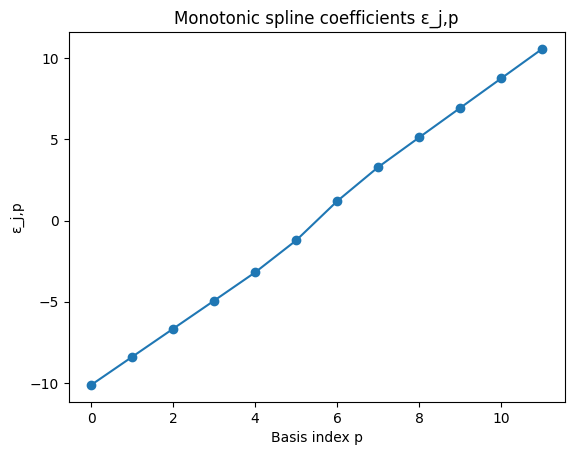

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9300, -8.1701, -6.2931, -4.4417, -2.6219, -0.8246,  0.9754,  2.7746,
         4.5674,  6.3485,  8.1140,  9.8744])


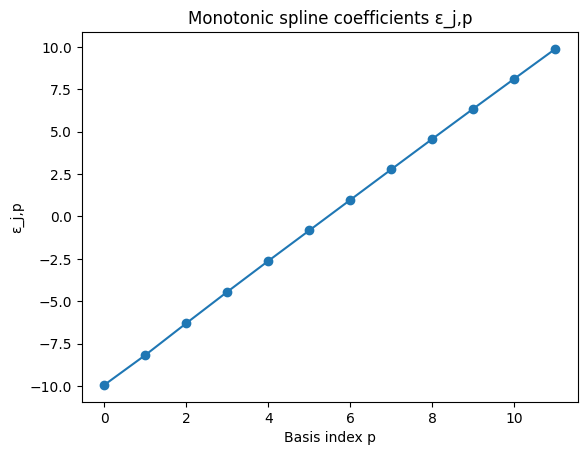

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1569,  -8.4480,  -6.7391,  -5.0301,  -3.3137,  -1.2892,   1.1446,
          3.1379,   4.9482,   6.7666,   8.5848,  10.4030])


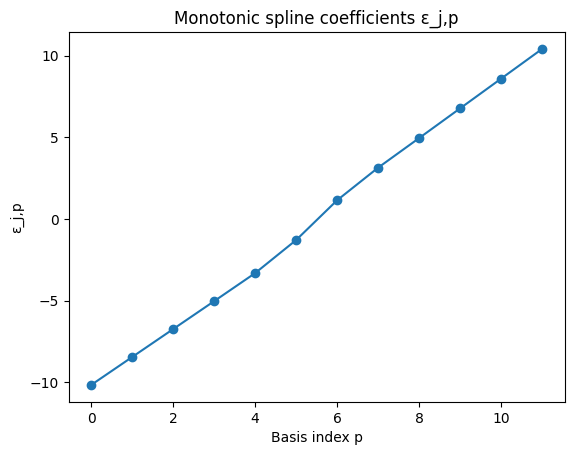

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9300, -8.1701, -6.2930, -4.4414, -2.6218, -0.8236,  0.9765,  2.7750,
         4.5681,  6.3514,  8.1200,  9.8810])


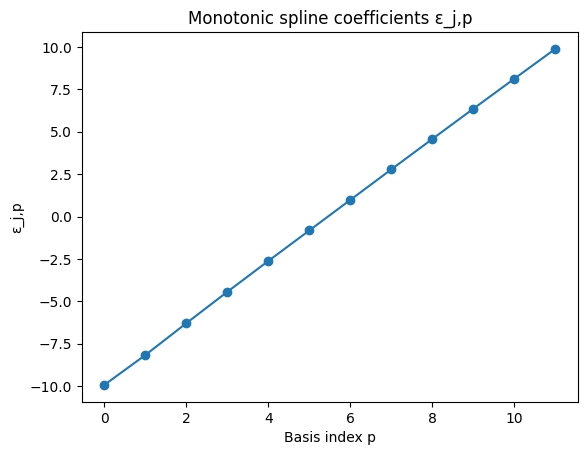

In [ ]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

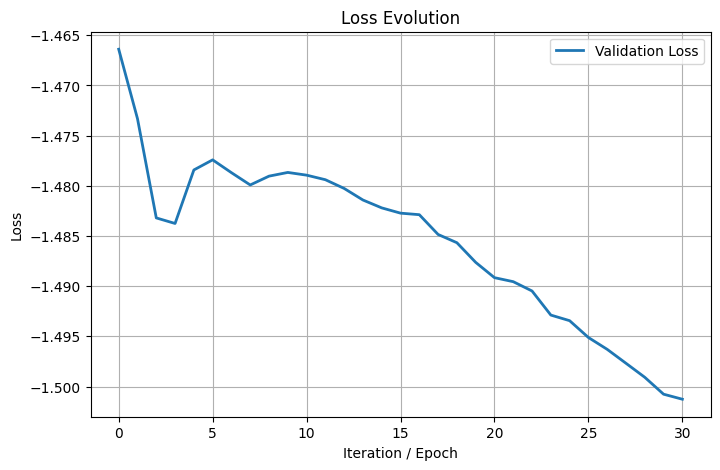

In [ ]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.9300,  1.5710,  1.7110,  1.6806,  1.6430,  1.6161,  1.6193,  1.6184,
         1.6107,  1.5966,  1.5779,  1.5716, -9.9300,  1.5710,  1.7110,  1.6809,
         1.6427,  1.6172,  1.6194,  1.6175,  1.6111,  1.5993,  1.5816,  1.5724],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6806,  1.6430,  1.6161,  1.6193,  1.6184,
         1.6107,  1.5966,  1.5779,  1.5716], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6809,  1.6427,  1.6172,  1.6194,  1.6175,
         1.6111,  1.5993,  1.5816,  1.5724], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.1246,   1.5368,   1.5368,   1.5368,   1.5482,   1.8175,   2.3242,
          1.9631,   1.6544,   1.6411,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.1569,   1.5092,   1.5092,   1

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [ ]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.091
KLD GTM      Train Data:  0.0071
KLD Gaussian Train Data:  -0.0007
KLD Copula   Train Data:  -0.0002

KLD BGTM      Test  Data:  0.0836
KLD GTM      Test  Data:  0.0059
KLD Gaussian Test  Data:  0.0002
KLD Copula   Test  Data:  0.0012


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

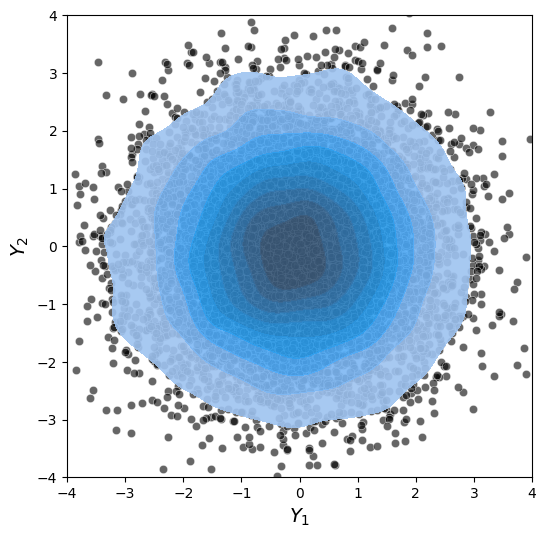

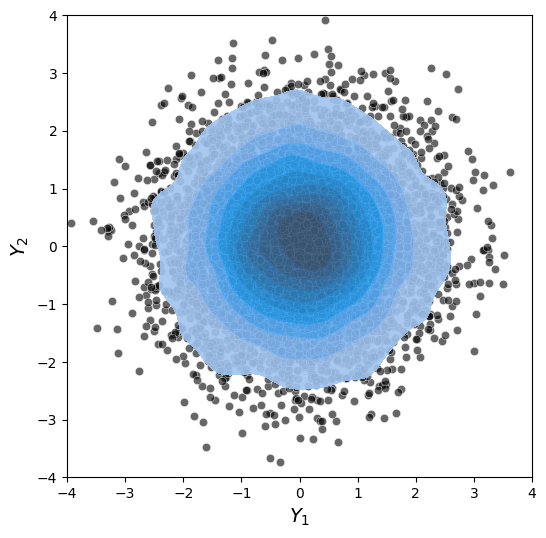

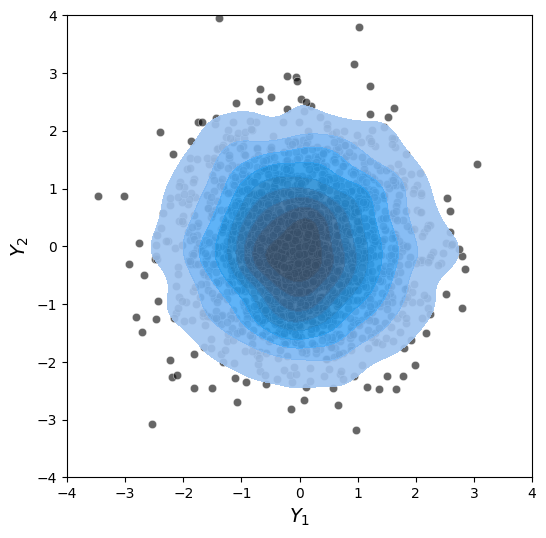

In [ ]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [20]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

In [21]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### BGTM model

In [ ]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<34:36, 10.44s/it]

[1/200] train=20386.6646  val_ELPD=-1.9516  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.96  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600831  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03μ-nudge(±)≈-1.12


  1%|          | 2/200 [00:20<34:29, 10.45s/it]

[2/200] train=75.0606  val_ELPD=-1.8208  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.02  priors/obs: decor≈0 trans≈23.6  tau4=0.618105  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.31  Δ=+1.73e-02μ-nudge(±)≈-14.1


  2%|▏         | 3/200 [00:31<34:14, 10.43s/it]

[3/200] train=74.2544  val_ELPD=-1.6957  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈12.77  priors/obs: decor≈0 trans≈23.3  tau4=0.628505  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈22.2  target≈22.2  resid≈0.184  Δ=+1.04e-02μ-nudge(±)≈8.54


  2%|▏         | 4/200 [00:41<34:03, 10.43s/it]

[4/200] train=72.5867  val_ELPD=-1.6385  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈11.83  priors/obs: decor≈0 trans≈22.8  tau4=0.629277  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈22  target≈22.2  resid≈0.135  Δ=+7.73e-04μ-nudge(±)≈2.55


  2%|▎         | 5/200 [00:52<33:51, 10.42s/it]

[5/200] train=71.0318  val_ELPD=-1.6187  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈11.44  priors/obs: decor≈0 trans≈22  tau4=0.630854  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.7  target≈22.2  resid≈0.271  Δ=+1.58e-03μ-nudge(±)≈3.34


  3%|▎         | 6/200 [01:02<33:39, 10.41s/it]

[6/200] train=69.9644  val_ELPD=-1.6074  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈11.39  priors/obs: decor≈0 trans≈21.2  tau4=0.633481  rank=20  E_qf_mean≈16.9  E_qf_total≈33.8  tau*E_qf≈21.4  target≈22.2  resid≈0.444  Δ=+2.63e-03μ-nudge(±)≈1.77


  4%|▎         | 7/200 [01:12<33:30, 10.42s/it]

[7/200] train=69.2749  val_ELPD=-1.5955  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0527 σmin=0.0501 σmax=0.0532  N=2000 B=200 B̄≈285.7  lik/obs≈11.38  priors/obs: decor≈0 trans≈20.5  tau4=0.637377  rank=20  E_qf_mean≈16.5  E_qf_total≈33  tau*E_qf≈21  target≈22.2  resid≈0.643  Δ=+3.90e-03μ-nudge(±)≈-1.31


  4%|▍         | 8/200 [01:23<33:22, 10.43s/it]

[8/200] train=67.8263  val_ELPD=-1.5841  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0546 σmin=0.0519 σmax=0.0551  N=2000 B=200 B̄≈285.7  lik/obs≈11.29  priors/obs: decor≈0 trans≈19.8  tau4=0.642548  rank=20  E_qf_mean≈16.1  E_qf_total≈32.2  tau*E_qf≈20.7  target≈22.2  resid≈0.833  Δ=+5.17e-03μ-nudge(±)≈3.06


  4%|▍         | 9/200 [01:33<33:14, 10.44s/it]

[9/200] train=65.9593  val_ELPD=-1.5729  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0566 σmin=0.0538 σmax=0.0571  N=2000 B=200 B̄≈285.7  lik/obs≈11.18  priors/obs: decor≈0 trans≈19.2  tau4=0.655339  rank=20  E_qf_mean≈15.7  E_qf_total≈31.4  tau*E_qf≈20.6  target≈22.2  resid≈1  Δ=+1.28e-02μ-nudge(±)≈-2.08


  5%|▌         | 10/200 [01:44<33:03, 10.44s/it]

[10/200] train=64.8906  val_ELPD=-1.5639  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0588 σmin=0.0558 σmax=0.0593  N=2000 B=200 B̄≈285.7  lik/obs≈11.08  priors/obs: decor≈0 trans≈18.7  tau4=0.669205  rank=20  E_qf_mean≈15.3  E_qf_total≈30.6  tau*E_qf≈20.5  target≈22.2  resid≈1.06  Δ=+1.39e-02μ-nudge(±)≈0.226


  6%|▌         | 11/200 [01:54<33:02, 10.49s/it]

[11/200] train=63.0985  val_ELPD=-1.5566  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0610 σmin=0.0579 σmax=0.0615  N=2000 B=200 B̄≈285.7  lik/obs≈11.02  priors/obs: decor≈0 trans≈18.2  tau4=0.684067  rank=20  E_qf_mean≈14.9  E_qf_total≈29.9  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.49e-02μ-nudge(±)≈0.0951


  6%|▌         | 12/200 [02:05<32:48, 10.47s/it]

[12/200] train=61.4557  val_ELPD=-1.5512  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0632 σmin=0.0601 σmax=0.0638  N=2000 B=200 B̄≈285.7  lik/obs≈10.97  priors/obs: decor≈0 trans≈17.6  tau4=0.699887  rank=20  E_qf_mean≈14.5  E_qf_total≈29.1  tau*E_qf≈20.4  target≈22.2  resid≈1.15  Δ=+1.58e-02μ-nudge(±)≈-1.12


  6%|▋         | 13/200 [02:15<32:37, 10.47s/it]

[13/200] train=59.8523  val_ELPD=-1.5472  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0656 σmin=0.0623 σmax=0.0661  N=2000 B=200 B̄≈285.7  lik/obs≈10.93  priors/obs: decor≈0 trans≈17.1  tau4=0.71667  rank=20  E_qf_mean≈14.2  E_qf_total≈28.3  tau*E_qf≈20.3  target≈22.2  resid≈1.19  Δ=+1.68e-02μ-nudge(±)≈-1.68


  7%|▋         | 14/200 [02:26<32:29, 10.48s/it]

[14/200] train=58.1968  val_ELPD=-1.5439  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0680 σmin=0.0646 σmax=0.0685  N=2000 B=200 B̄≈285.7  lik/obs≈10.93  priors/obs: decor≈0 trans≈16.5  tau4=0.734446  rank=20  E_qf_mean≈13.8  E_qf_total≈27.6  tau*E_qf≈20.2  target≈22.2  resid≈1.22  Δ=+1.78e-02μ-nudge(±)≈0.952


  8%|▊         | 15/200 [02:36<32:19, 10.49s/it]

[15/200] train=56.3577  val_ELPD=-1.5399  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0704 σmin=0.0669 σmax=0.0710  N=2000 B=200 B̄≈285.7  lik/obs≈10.91  priors/obs: decor≈0 trans≈15.9  tau4=0.753272  rank=20  E_qf_mean≈13.4  E_qf_total≈26.8  tau*E_qf≈20.2  target≈22.2  resid≈1.26  Δ=+1.88e-02μ-nudge(±)≈-0.362


  8%|▊         | 16/200 [02:47<32:10, 10.49s/it]

[16/200] train=55.5270  val_ELPD=-1.5388  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0729 σmin=0.0693 σmax=0.0735  N=2000 B=200 B̄≈285.7  lik/obs≈10.92  priors/obs: decor≈0 trans≈15.2  tau4=0.773244  rank=20  E_qf_mean≈13  E_qf_total≈26  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+2.00e-02μ-nudge(±)≈3.07


  8%|▊         | 17/200 [02:57<32:00, 10.50s/it]

[17/200] train=54.4827  val_ELPD=-1.5355  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0755 σmin=0.0718 σmax=0.0761  N=2000 B=200 B̄≈285.7  lik/obs≈10.88  priors/obs: decor≈0 trans≈14.6  tau4=0.7944  rank=20  E_qf_mean≈12.6  E_qf_total≈25.3  tau*E_qf≈20.1  target≈22.2  resid≈1.34  Δ=+2.12e-02μ-nudge(±)≈-0.847


  9%|▉         | 18/200 [03:08<31:50, 10.50s/it]

[18/200] train=52.8363  val_ELPD=-1.5353  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0781 σmin=0.0743 σmax=0.0788  N=2000 B=200 B̄≈285.7  lik/obs≈10.89  priors/obs: decor≈0 trans≈14  tau4=0.816819  rank=20  E_qf_mean≈12.2  E_qf_total≈24.5  tau*E_qf≈20  target≈22.2  resid≈1.37  Δ=+2.24e-02μ-nudge(±)≈1.42


 10%|▉         | 19/200 [03:18<31:40, 10.50s/it]

[19/200] train=51.0063  val_ELPD=-1.5348  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0808 σmin=0.0769 σmax=0.0815  N=2000 B=200 B̄≈285.7  lik/obs≈10.9  priors/obs: decor≈0 trans≈13.3  tau4=0.840546  rank=20  E_qf_mean≈11.9  E_qf_total≈23.7  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+2.37e-02μ-nudge(±)≈0.601


 10%|█         | 20/200 [03:29<31:29, 10.50s/it]

[20/200] train=49.4833  val_ELPD=-1.5354  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0836 σmin=0.0795 σmax=0.0844  N=2000 B=200 B̄≈285.7  lik/obs≈10.91  priors/obs: decor≈0 trans≈12.6  tau4=0.865628  rank=20  E_qf_mean≈11.5  E_qf_total≈23  tau*E_qf≈19.9  target≈22.2  resid≈1.44  Δ=+2.51e-02μ-nudge(±)≈-3.54


 10%|█         | 21/200 [03:39<31:19, 10.50s/it]

[21/200] train=48.5607  val_ELPD=-1.5361  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0865 σmin=0.0822 σmax=0.0873  N=2000 B=200 B̄≈285.7  lik/obs≈10.91  priors/obs: decor≈0 trans≈11.9  tau4=0.892212  rank=20  E_qf_mean≈11.1  E_qf_total≈22.2  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+2.66e-02μ-nudge(±)≈-1.44


 11%|█         | 22/200 [03:50<31:09, 10.50s/it]

[22/200] train=46.3385  val_ELPD=-1.5379  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0894 σmin=0.0850 σmax=0.0902  N=2000 B=200 B̄≈285.7  lik/obs≈10.92  priors/obs: decor≈0 trans≈11.2  tau4=0.920281  rank=20  E_qf_mean≈10.7  E_qf_total≈21.5  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+2.81e-02μ-nudge(±)≈-2.84


 12%|█▏        | 23/200 [04:00<30:58, 10.50s/it]

[23/200] train=45.1341  val_ELPD=-1.5384  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0924 σmin=0.0879 σmax=0.0933  N=2000 B=200 B̄≈285.7  lik/obs≈10.94  priors/obs: decor≈0 trans≈10.5  tau4=0.949989  rank=20  E_qf_mean≈10.4  E_qf_total≈20.8  tau*E_qf≈19.7  target≈22.2  resid≈1.54  Δ=+2.97e-02μ-nudge(±)≈4.34


 12%|█▏        | 24/200 [04:11<30:47, 10.50s/it]

[24/200] train=43.7121  val_ELPD=-1.5413  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0955 σmin=0.0908 σmax=0.0964  N=2000 B=200 B̄≈285.7  lik/obs≈10.97  priors/obs: decor≈0 trans≈9.8  tau4=0.981415  rank=20  E_qf_mean≈10  E_qf_total≈20.1  tau*E_qf≈19.7  target≈22.2  resid≈1.58  Δ=+3.14e-02μ-nudge(±)≈-0.532


 12%|█▎        | 25/200 [04:21<30:37, 10.50s/it]

[25/200] train=42.4761  val_ELPD=-1.5438  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0987 σmin=0.0938 σmax=0.0996  N=2000 B=200 B̄≈285.7  lik/obs≈11  priors/obs: decor≈0 trans≈9.06  tau4=1.01471  rank=20  E_qf_mean≈9.67  E_qf_total≈19.3  tau*E_qf≈19.6  target≈22.2  resid≈1.61  Δ=+3.33e-02μ-nudge(±)≈-0.985


 13%|█▎        | 26/200 [04:32<30:27, 10.50s/it]

[26/200] train=40.9377  val_ELPD=-1.5474  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.1020 σmin=0.0969 σmax=0.1029  N=2000 B=200 B̄≈285.7  lik/obs≈11.01  priors/obs: decor≈0 trans≈8.31  tau4=1.0498  rank=20  E_qf_mean≈9.33  E_qf_total≈18.7  tau*E_qf≈19.6  target≈22.2  resid≈1.64  Δ=+3.51e-02μ-nudge(±)≈-1.06


 14%|█▎        | 27/200 [04:42<30:16, 10.50s/it]

[27/200] train=39.1364  val_ELPD=-1.5511  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.1053 σmin=0.1001 σmax=0.1063  N=2000 B=200 B̄≈285.7  lik/obs≈11.04  priors/obs: decor≈0 trans≈7.54  tau4=1.08697  rank=20  E_qf_mean≈8.98  E_qf_total≈18  tau*E_qf≈19.5  target≈22.2  resid≈1.67  Δ=+3.72e-02μ-nudge(±)≈-3.13


 14%|█▍        | 28/200 [04:53<30:15, 10.55s/it]

[28/200] train=37.6238  val_ELPD=-1.5537  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1087 σmin=0.1033 σmax=0.1098  N=2000 B=200 B̄≈285.7  lik/obs≈11.09  priors/obs: decor≈0 trans≈6.77  tau4=1.12628  rank=20  E_qf_mean≈8.65  E_qf_total≈17.3  tau*E_qf≈19.5  target≈22.2  resid≈1.7  Δ=+3.93e-02μ-nudge(±)≈-2.87


 14%|█▍        | 29/200 [05:03<30:00, 10.53s/it]

[29/200] train=36.3834  val_ELPD=-1.5546  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1112 σmin=0.1056 σmax=0.1123  N=2000 B=200 B̄≈285.7  lik/obs≈11.15  priors/obs: decor≈0 trans≈6.13  tau4=1.16648  rank=20  E_qf_mean≈8.36  E_qf_total≈16.7  tau*E_qf≈19.5  target≈22.2  resid≈1.68  Δ=+4.02e-02μ-nudge(±)≈0.0549


 15%|█▌        | 30/200 [05:14<29:46, 10.51s/it]

[30/200] train=35.8368  val_ELPD=-1.5579  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1137 σmin=0.1080 σmax=0.1148  N=2000 B=200 B̄≈285.7  lik/obs≈11.15  priors/obs: decor≈0 trans≈5.67  tau4=1.20611  rank=20  E_qf_mean≈8.13  E_qf_total≈16.3  tau*E_qf≈19.6  target≈22.2  resid≈1.61  Δ=+3.96e-02μ-nudge(±)≈1.45


 16%|█▌        | 31/200 [05:24<29:34, 10.50s/it]

[31/200] train=34.6382  val_ELPD=-1.5584  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1162 σmin=0.1104 σmax=0.1174  N=2000 B=200 B̄≈285.7  lik/obs≈11.17  priors/obs: decor≈0 trans≈5.18  tau4=1.24569  rank=20  E_qf_mean≈7.9  E_qf_total≈15.8  tau*E_qf≈19.7  target≈22.2  resid≈1.56  Δ=+3.96e-02μ-nudge(±)≈-2.36


 16%|█▌        | 32/200 [05:35<29:21, 10.48s/it]

[32/200] train=32.8445  val_ELPD=-1.5648  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1188 σmin=0.1128 σmax=0.1200  N=2000 B=200 B̄≈285.7  lik/obs≈11.22  priors/obs: decor≈0 trans≈4.68  tau4=1.28548  rank=20  E_qf_mean≈7.68  E_qf_total≈15.4  tau*E_qf≈19.8  target≈22.2  resid≈1.53  Δ=+3.98e-02μ-nudge(±)≈0.0845


 16%|█▋        | 33/200 [05:45<29:07, 10.47s/it]

[33/200] train=32.3393  val_ELPD=-1.5661  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1214 σmin=0.1153 σmax=0.1227  N=2000 B=200 B̄≈285.7  lik/obs≈11.24  priors/obs: decor≈0 trans≈4.17  tau4=1.32588  rank=20  E_qf_mean≈7.46  E_qf_total≈14.9  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+4.04e-02μ-nudge(±)≈5.34


 17%|█▋        | 34/200 [05:56<28:53, 10.44s/it]

[34/200] train=31.3561  val_ELPD=-1.5732  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1240 σmin=0.1178 σmax=0.1254  N=2000 B=200 B̄≈285.7  lik/obs≈11.3  priors/obs: decor≈0 trans≈3.64  tau4=1.36731  rank=20  E_qf_mean≈7.24  E_qf_total≈14.5  tau*E_qf≈19.8  target≈22.2  resid≈1.5  Δ=+4.14e-02μ-nudge(±)≈6.17


 18%|█▊        | 35/200 [06:06<28:39, 10.42s/it]

[35/200] train=30.0541  val_ELPD=-1.5756  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1267 σmin=0.1203 σmax=0.1281  N=2000 B=200 B̄≈285.7  lik/obs≈11.34  priors/obs: decor≈0 trans≈3.11  tau4=1.40961  rank=20  E_qf_mean≈7.03  E_qf_total≈14.1  tau*E_qf≈19.8  target≈22.2  resid≈1.49  Δ=+4.23e-02μ-nudge(±)≈0.0484


 18%|█▊        | 36/200 [06:16<28:27, 10.41s/it]

[36/200] train=29.6870  val_ELPD=-1.5782  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1295 σmin=0.1229 σmax=0.1309  N=2000 B=200 B̄≈285.7  lik/obs≈11.37  priors/obs: decor≈0 trans≈2.56  tau4=1.45365  rank=20  E_qf_mean≈6.81  E_qf_total≈13.6  tau*E_qf≈19.8  target≈22.2  resid≈1.5  Δ=+4.40e-02μ-nudge(±)≈-4.53


 18%|█▊        | 37/200 [06:27<28:15, 10.40s/it]

[37/200] train=28.2070  val_ELPD=-1.5852  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1323 σmin=0.1255 σmax=0.1338  N=2000 B=200 B̄≈285.7  lik/obs≈11.41  priors/obs: decor≈0 trans≈2.01  tau4=1.49924  rank=20  E_qf_mean≈6.6  E_qf_total≈13.2  tau*E_qf≈19.8  target≈22.2  resid≈1.5  Δ=+4.56e-02μ-nudge(±)≈7.74


 19%|█▉        | 38/200 [06:37<28:04, 10.40s/it]

[38/200] train=26.8749  val_ELPD=-1.5892  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1351 σmin=0.1282 σmax=0.1367  N=2000 B=200 B̄≈285.7  lik/obs≈11.47  priors/obs: decor≈0 trans≈1.46  tau4=1.54648  rank=20  E_qf_mean≈6.4  E_qf_total≈12.8  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+4.72e-02μ-nudge(±)≈3.71


 20%|█▉        | 39/200 [06:48<27:53, 10.39s/it]

[39/200] train=25.7529  val_ELPD=-1.5858  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1372 σmin=0.1301 σmax=0.1388  N=2000 B=200 B̄≈285.7  lik/obs≈11.52  priors/obs: decor≈0 trans≈1.01  tau4=1.59428  rank=20  E_qf_mean≈6.22  E_qf_total≈12.4  tau*E_qf≈19.8  target≈22.2  resid≈1.49  Δ=+4.78e-02μ-nudge(±)≈0.459


 20%|██        | 40/200 [06:58<27:42, 10.39s/it]

[40/200] train=25.6760  val_ELPD=-1.5905  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1392 σmin=0.1320 σmax=0.1409  N=2000 B=200 B̄≈285.7  lik/obs≈11.5  priors/obs: decor≈0 trans≈0.699  tau4=1.64086  rank=20  E_qf_mean≈6.07  E_qf_total≈12.1  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+4.66e-02μ-nudge(±)≈-1.59


 20%|██        | 41/200 [07:08<27:32, 10.40s/it]

[41/200] train=24.9890  val_ELPD=-1.5959  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1413 σmin=0.1340 σmax=0.1430  N=2000 B=200 B̄≈285.7  lik/obs≈11.53  priors/obs: decor≈0 trans≈0.369  tau4=1.68689  rank=20  E_qf_mean≈5.93  E_qf_total≈11.9  tau*E_qf≈20  target≈22.2  resid≈1.37  Δ=+4.60e-02μ-nudge(±)≈-0.229


 21%|██        | 42/200 [07:19<27:22, 10.40s/it]

[42/200] train=24.7334  val_ELPD=-1.6010  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1434 σmin=0.1360 σmax=0.1452  N=2000 B=200 B̄≈285.7  lik/obs≈11.6  priors/obs: decor≈0 trans≈0.00382  tau4=1.73368  rank=20  E_qf_mean≈5.78  E_qf_total≈11.6  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+4.68e-02μ-nudge(±)≈6.38


 22%|██▏       | 43/200 [07:29<27:15, 10.42s/it]

[43/200] train=23.8479  val_ELPD=-1.6043  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1455 σmin=0.1380 σmax=0.1474  N=2000 B=200 B̄≈285.7  lik/obs≈11.62  priors/obs: decor≈0 trans≈-0.324  tau4=1.77971  rank=20  E_qf_mean≈5.65  E_qf_total≈11.3  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+4.60e-02μ-nudge(±)≈-4.52


 22%|██▏       | 44/200 [07:40<27:08, 10.44s/it]

[44/200] train=23.2456  val_ELPD=-1.6009  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1476 σmin=0.1400 σmax=0.1496  N=2000 B=200 B̄≈285.7  lik/obs≈11.62  priors/obs: decor≈0 trans≈-0.703  tau4=1.82703  rank=20  E_qf_mean≈5.5  E_qf_total≈11  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+4.73e-02μ-nudge(±)≈-3.58


 22%|██▎       | 45/200 [07:50<27:00, 10.46s/it]

[45/200] train=22.3524  val_ELPD=-1.6055  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1498 σmin=0.1420 σmax=0.1518  N=2000 B=200 B̄≈285.7  lik/obs≈11.65  priors/obs: decor≈0 trans≈-1.07  tau4=1.87494  rank=20  E_qf_mean≈5.37  E_qf_total≈10.7  tau*E_qf≈20.1  target≈22.2  resid≈1.29  Δ=+4.79e-02μ-nudge(±)≈-1.28


 23%|██▎       | 46/200 [08:01<26:51, 10.46s/it]

[46/200] train=21.7916  val_ELPD=-1.6130  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1520 σmin=0.1441 σmax=0.1541  N=2000 B=200 B̄≈285.7  lik/obs≈11.8  priors/obs: decor≈0 trans≈-1.44  tau4=1.92382  rank=20  E_qf_mean≈5.24  E_qf_total≈10.5  tau*E_qf≈20.1  target≈22.2  resid≈1.28  Δ=+4.89e-02μ-nudge(±)≈-1.62


 24%|██▎       | 47/200 [08:11<26:41, 10.47s/it]

[47/200] train=20.6158  val_ELPD=-1.6169  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1542 σmin=0.1462 σmax=0.1564  N=2000 B=200 B̄≈285.7  lik/obs≈11.81  priors/obs: decor≈0 trans≈-1.82  tau4=1.97424  rank=20  E_qf_mean≈5.1  E_qf_total≈10.2  tau*E_qf≈20.1  target≈22.2  resid≈1.29  Δ=+5.04e-02μ-nudge(±)≈1.36


 24%|██▍       | 48/200 [08:22<26:32, 10.48s/it]

[48/200] train=20.3856  val_ELPD=-1.6218  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1565 σmin=0.1483 σmax=0.1587  N=2000 B=200 B̄≈285.7  lik/obs≈11.82  priors/obs: decor≈0 trans≈-2.24  tau4=2.02753  rank=20  E_qf_mean≈4.95  E_qf_total≈9.91  tau*E_qf≈20.1  target≈22.2  resid≈1.32  Δ=+5.33e-02μ-nudge(±)≈19.4


 24%|██▍       | 48/200 [08:32<27:03, 10.68s/it]

[49/200] train=20.0616  val_ELPD=-1.6204  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1581 σmin=0.1498 σmax=0.1604  N=2000 B=200 B̄≈285.7  lik/obs≈11.88  priors/obs: decor≈0 trans≈-2.53  tau4=2.08056  rank=20  E_qf_mean≈4.84  E_qf_total≈9.68  tau*E_qf≈20.1  target≈22.2  resid≈1.28  Δ=+5.30e-02μ-nudge(±)≈-7.25
Early stop @ epoch 49: no val improvement for 30 epochs.


### GTM model

In [23]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:17,  7.28it/s]

current_loss: tensor(2.0748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5043,

  0%|          | 3/1000 [00:00<02:10,  7.67it/s]

current_loss: tensor(1.5149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4853,

  0%|          | 4/1000 [00:00<02:09,  7.71it/s]

current_loss: tensor(1.4540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4995,

  1%|          | 6/1000 [00:00<02:07,  7.77it/s]

current_loss: tensor(1.4793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565,

  1%|          | 7/1000 [00:00<02:07,  7.77it/s]

current_loss: tensor(1.5014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5040,

  1%|          | 9/1000 [00:01<02:09,  7.68it/s]

current_loss: tensor(1.4532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494,

  1%|          | 11/1000 [00:01<02:10,  7.59it/s]

current_loss: tensor(1.5029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4943,

  1%|          | 12/1000 [00:01<02:11,  7.51it/s]

current_loss: tensor(1.4507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4862,

  1%|▏         | 14/1000 [00:01<02:08,  7.66it/s]

current_loss: tensor(1.5012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4711,

  2%|▏         | 15/1000 [00:01<02:07,  7.70it/s]

current_loss: tensor(1.4864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4949,

  2%|▏         | 17/1000 [00:02<02:08,  7.65it/s]

current_loss: tensor(1.4705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504,

  2%|▏         | 18/1000 [00:02<02:07,  7.69it/s]

current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5005,

  2%|▏         | 20/1000 [00:02<02:06,  7.76it/s]

current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4441,

  2%|▏         | 22/1000 [00:02<02:05,  7.78it/s]

current_loss: tensor(1.5001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4904,

  2%|▏         | 23/1000 [00:02<02:05,  7.79it/s]

current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4901,

  2%|▎         | 25/1000 [00:03<02:04,  7.80it/s]

current_loss: tensor(1.4901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494,

  3%|▎         | 26/1000 [00:03<02:04,  7.80it/s]

current_loss: tensor(1.4894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4994,

  3%|▎         | 28/1000 [00:03<02:04,  7.81it/s]

current_loss: tensor(1.4492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421,

  3%|▎         | 28/1000 [00:03<02:10,  7.45it/s]

current_loss: tensor(1.4991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
Early Stop at iteration 28 with minimal loss tensor(1.4488, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0433,  -8.2640,  -6.4848,  -4.7057,  -2.9711,  -1.4469,  -0.2551,
          0.8670,   2.2578,   4.0471,   5.8661,   7.6843])


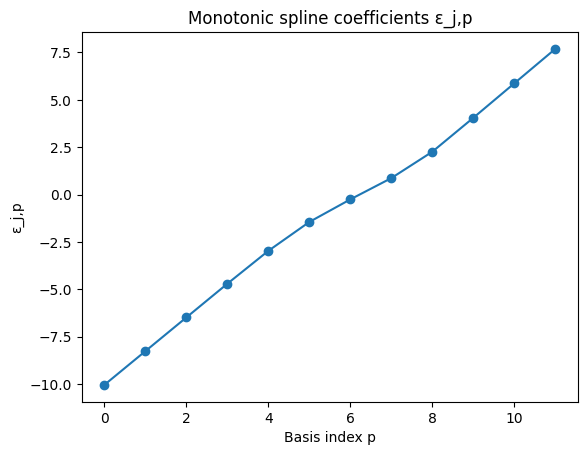

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0664, -8.0258, -5.9540, -4.3972, -2.9483, -1.5486, -0.2888,  0.8056,
         1.7088,  2.4941,  3.2615,  4.0272])


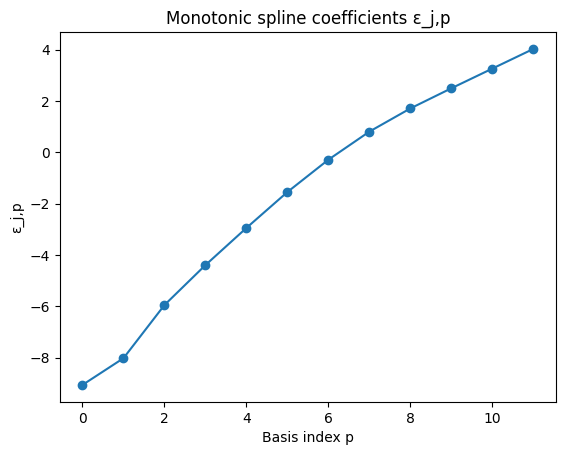

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2097,  -8.5380,  -6.8663,  -5.1947,  -3.5079,  -0.7804,   2.8565,
          4.8156,   6.6338,   8.4520,  10.2702,  12.0883])


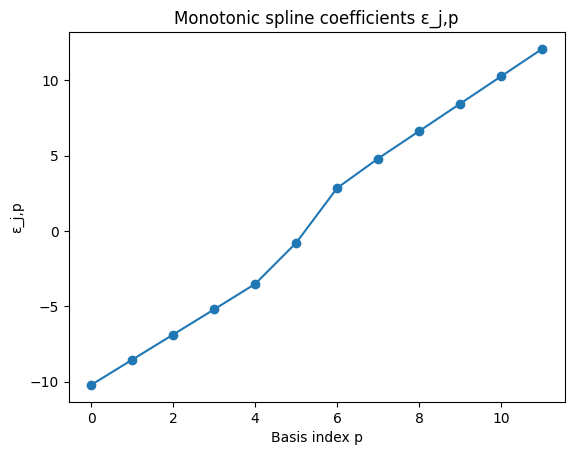

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.8482, -7.9180, -5.5428, -4.2853, -3.0692, -0.5957,  2.0249,  2.8857,
         3.6602,  4.4383,  5.2110,  5.9772])


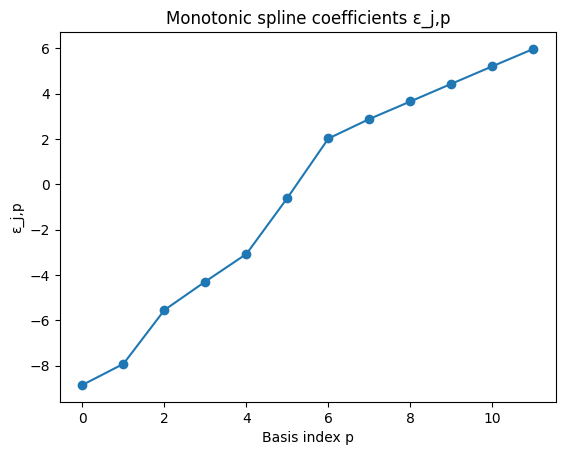

In [ ]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

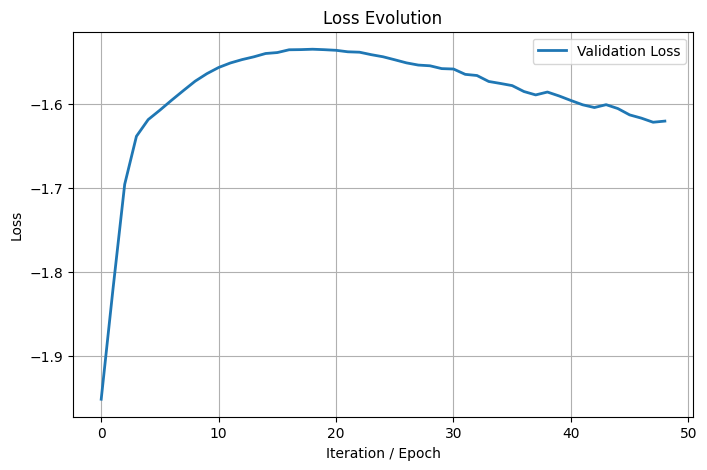

In [ ]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [27]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [28]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.147
KLD GTM      Train Data:  0.0141
KLD Gaussian Train Data:  -0.0011
KLD Copula   Train Data:  -0.001

KLD BGTM      Test  Data:  0.162
KLD GTM      Test  Data:  0.0268
KLD Gaussian Test  Data:  0.0008
KLD Copula   Test  Data:  0.0008


In [29]:
#model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1262: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


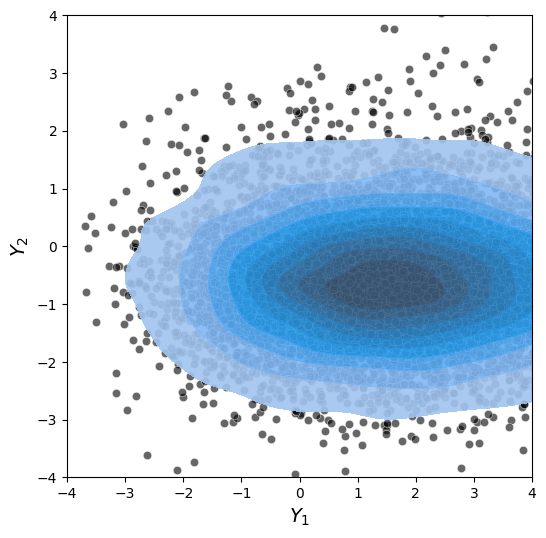

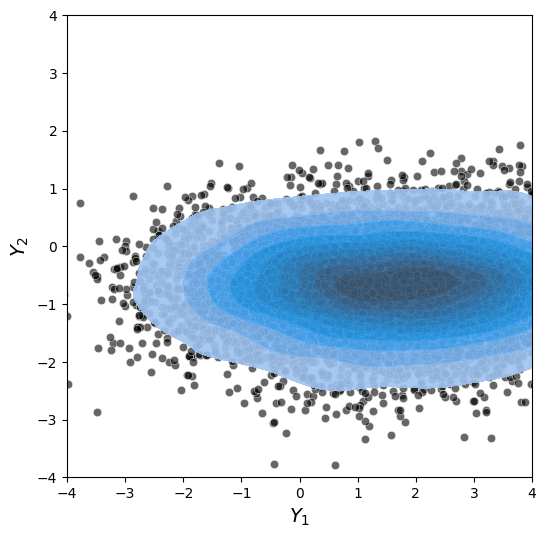

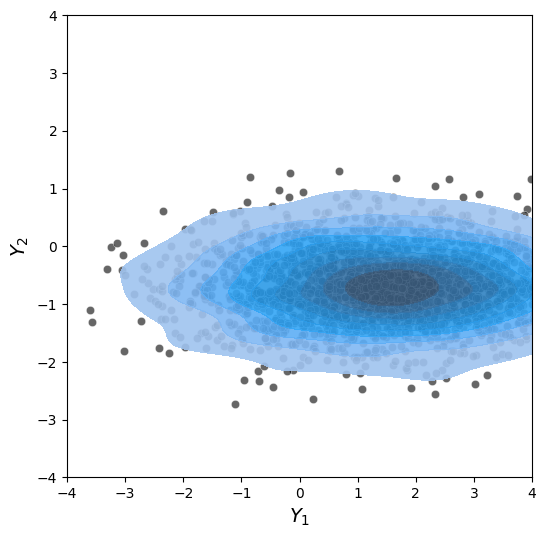

In [ ]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [31]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [32]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

# BGTM

In [ ]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=2000  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:01<05:22,  1.62s/it]

[1/200] train=20651.3418  val_ELPD=-2.0664  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0502 σmin=0.0498 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.132  priors/obs: decor≈0 trans≈2.06e+04  tau4=0.592767  rank=20  E_qf_mean≈18.7  E_qf_total≈37.4  tau*E_qf≈22.2  target≈22.2  resid≈-2.06e+04  Δ=-1.10e+03μ-nudge(±)≈-26.8


  1%|          | 2/200 [00:03<05:18,  1.61s/it]

[2/200] train=64.5570  val_ELPD=-2.0509  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0502 σmin=0.0498 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.122  priors/obs: decor≈0 trans≈24.1  tau4=0.595461  rank=20  E_qf_mean≈18.6  E_qf_total≈37.3  tau*E_qf≈22.2  target≈22.2  resid≈0.0502  Δ=+2.69e-03μ-nudge(±)≈26.9


  2%|▏         | 3/200 [00:04<05:16,  1.61s/it]

[3/200] train=65.1137  val_ELPD=-2.0425  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0502 σmin=0.0498 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.117  priors/obs: decor≈0 trans≈24.1  tau4=0.597825  rank=20  E_qf_mean≈18.6  E_qf_total≈37.1  tau*E_qf≈22.2  target≈22.2  resid≈0.0439  Δ=+2.36e-03μ-nudge(±)≈-35.8


  2%|▏         | 4/200 [00:06<05:14,  1.61s/it]

[4/200] train=64.6210  val_ELPD=-2.0230  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0502 σmin=0.0498 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.111  priors/obs: decor≈0 trans≈24  tau4=0.598046  rank=20  E_qf_mean≈18.5  E_qf_total≈37  tau*E_qf≈22.1  target≈22.2  resid≈0.0407  Δ=+2.20e-04μ-nudge(±)≈12.2


  2%|▎         | 5/200 [00:08<05:12,  1.60s/it]

[5/200] train=63.5157  val_ELPD=-2.0458  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0502 σmin=0.0498 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.105  priors/obs: decor≈0 trans≈23.9  tau4=0.598466  rank=20  E_qf_mean≈18.4  E_qf_total≈36.9  tau*E_qf≈22.1  target≈22.2  resid≈0.0776  Δ=+4.21e-04μ-nudge(±)≈-19.7


  3%|▎         | 6/200 [00:09<05:11,  1.60s/it]

[6/200] train=63.6145  val_ELPD=-2.0330  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0502 σmin=0.0498 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.097  priors/obs: decor≈0 trans≈23.7  tau4=0.599056  rank=20  E_qf_mean≈18.4  E_qf_total≈36.7  tau*E_qf≈22  target≈22.2  resid≈0.108  Δ=+5.90e-04μ-nudge(±)≈34.3


  4%|▎         | 7/200 [00:11<05:09,  1.60s/it]

[7/200] train=63.6905  val_ELPD=-2.0182  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0504 σmin=0.0499 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.092  priors/obs: decor≈0 trans≈23.6  tau4=0.599805  rank=20  E_qf_mean≈18.3  E_qf_total≈36.6  tau*E_qf≈22  target≈22.2  resid≈0.137  Δ=+7.49e-04μ-nudge(±)≈6.66


  4%|▍         | 8/200 [00:12<05:07,  1.60s/it]

[8/200] train=63.8297  val_ELPD=-2.0393  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0506 σmin=0.0501 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.088  priors/obs: decor≈0 trans≈23.5  tau4=0.600694  rank=20  E_qf_mean≈18.2  E_qf_total≈36.5  tau*E_qf≈21.9  target≈22.2  resid≈0.162  Δ=+8.89e-04μ-nudge(±)≈-13.1


  4%|▍         | 9/200 [00:14<05:06,  1.60s/it]

[9/200] train=62.5184  val_ELPD=-2.0350  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0508 σmin=0.0504 σmax=0.0509  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.082  priors/obs: decor≈0 trans≈23.4  tau4=0.601703  rank=20  E_qf_mean≈18.2  E_qf_total≈36.3  tau*E_qf≈21.9  target≈22.2  resid≈0.183  Δ=+1.01e-03μ-nudge(±)≈48.3


  5%|▌         | 10/200 [00:16<05:04,  1.60s/it]

[10/200] train=64.0213  val_ELPD=-2.0324  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0511 σmin=0.0506 σmax=0.0511  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.078  priors/obs: decor≈0 trans≈23.3  tau4=0.60283  rank=20  E_qf_mean≈18.1  E_qf_total≈36.2  tau*E_qf≈21.8  target≈22.2  resid≈0.204  Δ=+1.13e-03μ-nudge(±)≈14.9


  6%|▌         | 11/200 [00:17<05:03,  1.60s/it]

[11/200] train=60.9502  val_ELPD=-2.0142  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0508 σmax=0.0513  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.076  priors/obs: decor≈0 trans≈23.2  tau4=0.604051  rank=20  E_qf_mean≈18  E_qf_total≈36.1  tau*E_qf≈21.8  target≈22.2  resid≈0.22  Δ=+1.22e-03μ-nudge(±)≈58.8


  6%|▌         | 12/200 [00:19<05:01,  1.60s/it]

[12/200] train=62.7085  val_ELPD=-2.0198  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0515 σmin=0.0511 σmax=0.0516  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.073  priors/obs: decor≈0 trans≈23.1  tau4=0.605368  rank=20  E_qf_mean≈18  E_qf_total≈36  tau*E_qf≈21.8  target≈22.2  resid≈0.237  Δ=+1.32e-03μ-nudge(±)≈-64.4


  6%|▋         | 13/200 [00:20<04:59,  1.60s/it]

[13/200] train=63.7345  val_ELPD=-2.0310  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0518 σmin=0.0513 σmax=0.0518  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.072  priors/obs: decor≈0 trans≈23  tau4=0.606773  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈21.7  target≈22.2  resid≈0.252  Δ=+1.40e-03μ-nudge(±)≈2.43


  7%|▋         | 14/200 [00:22<04:57,  1.60s/it]

[14/200] train=60.6236  val_ELPD=-2.0130  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0520 σmin=0.0516 σmax=0.0521  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.07  priors/obs: decor≈0 trans≈22.9  tau4=0.608249  rank=20  E_qf_mean≈17.9  E_qf_total≈35.7  tau*E_qf≈21.7  target≈22.2  resid≈0.264  Δ=+1.48e-03μ-nudge(±)≈-19.5


  8%|▊         | 15/200 [00:24<04:56,  1.60s/it]

[15/200] train=61.9584  val_ELPD=-2.0313  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0523 σmin=0.0518 σmax=0.0523  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.068  priors/obs: decor≈0 trans≈22.8  tau4=0.609798  rank=20  E_qf_mean≈17.8  E_qf_total≈35.6  tau*E_qf≈21.7  target≈22.2  resid≈0.276  Δ=+1.55e-03μ-nudge(±)≈58.1


  8%|▊         | 16/200 [00:25<04:55,  1.60s/it]

[16/200] train=61.3198  val_ELPD=-2.0233  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0525 σmin=0.0521 σmax=0.0526  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.07  priors/obs: decor≈0 trans≈22.7  tau4=0.611412  rank=20  E_qf_mean≈17.7  E_qf_total≈35.5  tau*E_qf≈21.7  target≈22.2  resid≈0.286  Δ=+1.61e-03μ-nudge(±)≈33.6


  8%|▊         | 17/200 [00:27<04:53,  1.60s/it]

[17/200] train=60.9770  val_ELPD=-2.0237  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0528 σmin=0.0523 σmax=0.0528  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.068  priors/obs: decor≈0 trans≈22.6  tau4=0.61309  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈21.7  target≈22.2  resid≈0.297  Δ=+1.68e-03μ-nudge(±)≈-98.5


  9%|▉         | 18/200 [00:28<04:52,  1.61s/it]

[18/200] train=60.6165  val_ELPD=-2.0320  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0531 σmin=0.0526 σmax=0.0531  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.074  priors/obs: decor≈0 trans≈22.5  tau4=0.614826  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈21.6  target≈22.2  resid≈0.306  Δ=+1.74e-03μ-nudge(±)≈48


 10%|▉         | 19/200 [00:30<04:51,  1.61s/it]

[19/200] train=61.1941  val_ELPD=-2.0216  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0533 σmin=0.0528 σmax=0.0534  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.072  priors/obs: decor≈0 trans≈22.4  tau4=0.616617  rank=20  E_qf_mean≈17.5  E_qf_total≈35.1  tau*E_qf≈21.6  target≈22.2  resid≈0.314  Δ=+1.79e-03μ-nudge(±)≈60.2


 10%|█         | 20/200 [00:32<04:50,  1.61s/it]

[20/200] train=62.0489  val_ELPD=-2.0226  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0536 σmin=0.0531 σmax=0.0536  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.077  priors/obs: decor≈0 trans≈22.3  tau4=0.618463  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈21.6  target≈22.2  resid≈0.323  Δ=+1.85e-03μ-nudge(±)≈-25.5


 10%|█         | 21/200 [00:33<04:48,  1.61s/it]

[21/200] train=61.8623  val_ELPD=-1.9937  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0538 σmin=0.0534 σmax=0.0539  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.078  priors/obs: decor≈0 trans≈22.2  tau4=0.620357  rank=20  E_qf_mean≈17.4  E_qf_total≈34.8  tau*E_qf≈21.6  target≈22.2  resid≈0.33  Δ=+1.89e-03μ-nudge(±)≈25.3


 11%|█         | 22/200 [00:35<04:46,  1.61s/it]

[22/200] train=59.3015  val_ELPD=-2.0352  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0541 σmin=0.0536 σmax=0.0542  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.084  priors/obs: decor≈0 trans≈22.1  tau4=0.622293  rank=20  E_qf_mean≈17.4  E_qf_total≈34.7  tau*E_qf≈21.6  target≈22.2  resid≈0.336  Δ=+1.94e-03μ-nudge(±)≈37.6


 12%|█▏        | 23/200 [00:36<04:45,  1.61s/it]

[23/200] train=59.7221  val_ELPD=-2.0508  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0544 σmin=0.0539 σmax=0.0544  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.087  priors/obs: decor≈0 trans≈22  tau4=0.62428  rank=20  E_qf_mean≈17.3  E_qf_total≈34.6  tau*E_qf≈21.6  target≈22.2  resid≈0.344  Δ=+1.99e-03μ-nudge(±)≈-41.8


 12%|█▏        | 24/200 [00:38<04:42,  1.61s/it]

[24/200] train=59.8528  val_ELPD=-2.0378  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0546 σmin=0.0542 σmax=0.0547  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.095  priors/obs: decor≈0 trans≈21.9  tau4=0.626313  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.6  target≈22.2  resid≈0.35  Δ=+2.03e-03μ-nudge(±)≈74.1


 12%|█▎        | 25/200 [00:40<04:40,  1.60s/it]

[25/200] train=60.7479  val_ELPD=-2.0380  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0549 σmin=0.0544 σmax=0.0550  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.095  priors/obs: decor≈0 trans≈21.8  tau4=0.628391  rank=20  E_qf_mean≈17.2  E_qf_total≈34.3  tau*E_qf≈21.6  target≈22.2  resid≈0.356  Δ=+2.08e-03μ-nudge(±)≈-22


 13%|█▎        | 26/200 [00:41<04:38,  1.60s/it]

[26/200] train=59.6448  val_ELPD=-2.0397  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0552 σmin=0.0547 σmax=0.0552  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.102  priors/obs: decor≈0 trans≈21.7  tau4=0.630508  rank=20  E_qf_mean≈17.1  E_qf_total≈34.2  tau*E_qf≈21.5  target≈22.2  resid≈0.362  Δ=+2.12e-03μ-nudge(±)≈109


 14%|█▎        | 27/200 [00:43<04:36,  1.60s/it]

[27/200] train=59.4617  val_ELPD=-2.0523  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0555 σmin=0.0550 σmax=0.0555  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.108  priors/obs: decor≈0 trans≈21.6  tau4=0.632671  rank=20  E_qf_mean≈17  E_qf_total≈34  tau*E_qf≈21.5  target≈22.2  resid≈0.368  Δ=+2.16e-03μ-nudge(±)≈61.8


 14%|█▍        | 28/200 [00:44<04:34,  1.60s/it]

[28/200] train=59.5321  val_ELPD=-2.0536  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0557 σmin=0.0552 σmax=0.0558  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.111  priors/obs: decor≈0 trans≈21.5  tau4=0.634877  rank=20  E_qf_mean≈17  E_qf_total≈33.9  tau*E_qf≈21.5  target≈22.2  resid≈0.374  Δ=+2.21e-03μ-nudge(±)≈64.9


 14%|█▍        | 29/200 [00:46<04:33,  1.60s/it]

[29/200] train=57.7594  val_ELPD=-2.0678  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0560 σmin=0.0555 σmax=0.0560  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.118  priors/obs: decor≈0 trans≈21.4  tau4=0.637119  rank=20  E_qf_mean≈16.9  E_qf_total≈33.8  tau*E_qf≈21.5  target≈22.2  resid≈0.379  Δ=+2.24e-03μ-nudge(±)≈-55.3


 15%|█▌        | 30/200 [00:48<04:31,  1.60s/it]

[30/200] train=56.6644  val_ELPD=-2.0498  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0563 σmin=0.0558 σmax=0.0563  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.125  priors/obs: decor≈0 trans≈21.3  tau4=0.639402  rank=20  E_qf_mean≈16.8  E_qf_total≈33.6  tau*E_qf≈21.5  target≈22.2  resid≈0.384  Δ=+2.28e-03μ-nudge(±)≈-28.6


 16%|█▌        | 31/200 [00:49<04:30,  1.60s/it]

[31/200] train=58.2616  val_ELPD=-2.0600  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0565 σmin=0.0560 σmax=0.0565  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.129  priors/obs: decor≈0 trans≈21.2  tau4=0.64173  rank=20  E_qf_mean≈16.7  E_qf_total≈33.5  tau*E_qf≈21.5  target≈22.2  resid≈0.39  Δ=+2.33e-03μ-nudge(±)≈20.6


 16%|█▌        | 32/200 [00:51<04:28,  1.60s/it]

[32/200] train=57.9328  val_ELPD=-2.0684  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0567 σmin=0.0562 σmax=0.0567  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.137  priors/obs: decor≈0 trans≈21.2  tau4=0.644018  rank=20  E_qf_mean≈16.7  E_qf_total≈33.4  tau*E_qf≈21.5  target≈22.2  resid≈0.382  Δ=+2.29e-03μ-nudge(±)≈22.8


 16%|█▋        | 33/200 [00:53<04:35,  1.65s/it]

[33/200] train=58.3264  val_ELPD=-2.0621  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0569 σmin=0.0564 σmax=0.0569  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.138  priors/obs: decor≈0 trans≈21.1  tau4=0.64627  rank=20  E_qf_mean≈16.7  E_qf_total≈33.3  tau*E_qf≈21.5  target≈22.2  resid≈0.375  Δ=+2.25e-03μ-nudge(±)≈6.67


 17%|█▋        | 34/200 [00:54<04:31,  1.63s/it]

[34/200] train=57.9000  val_ELPD=-2.0807  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0571 σmin=0.0566 σmax=0.0571  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.143  priors/obs: decor≈0 trans≈21  tau4=0.648486  rank=20  E_qf_mean≈16.6  E_qf_total≈33.2  tau*E_qf≈21.5  target≈22.2  resid≈0.368  Δ=+2.22e-03μ-nudge(±)≈-52.7


 18%|█▊        | 35/200 [00:56<04:27,  1.62s/it]

[35/200] train=56.7853  val_ELPD=-2.0538  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0573 σmin=0.0567 σmax=0.0573  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.145  priors/obs: decor≈0 trans≈21  tau4=0.65068  rank=20  E_qf_mean≈16.6  E_qf_total≈33.1  tau*E_qf≈21.5  target≈22.2  resid≈0.363  Δ=+2.19e-03μ-nudge(±)≈15.3


 18%|█▊        | 36/200 [00:57<04:25,  1.62s/it]

[36/200] train=58.1607  val_ELPD=-2.0860  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0575 σmin=0.0569 σmax=0.0575  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.156  priors/obs: decor≈0 trans≈20.9  tau4=0.652862  rank=20  E_qf_mean≈16.5  E_qf_total≈33  tau*E_qf≈21.6  target≈22.2  resid≈0.36  Δ=+2.18e-03μ-nudge(±)≈27


 18%|█▊        | 37/200 [00:59<04:23,  1.62s/it]

[37/200] train=57.2146  val_ELPD=-2.0797  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0576 σmin=0.0571 σmax=0.0577  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.158  priors/obs: decor≈0 trans≈20.9  tau4=0.655025  rank=20  E_qf_mean≈16.5  E_qf_total≈32.9  tau*E_qf≈21.6  target≈22.2  resid≈0.356  Δ=+2.16e-03μ-nudge(±)≈108


 19%|█▉        | 38/200 [01:01<04:21,  1.61s/it]

[38/200] train=57.6345  val_ELPD=-2.0377  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0578 σmin=0.0573 σmax=0.0579  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.161  priors/obs: decor≈0 trans≈20.8  tau4=0.657173  rank=20  E_qf_mean≈16.4  E_qf_total≈32.8  tau*E_qf≈21.6  target≈22.2  resid≈0.352  Δ=+2.15e-03μ-nudge(±)≈2.52


 20%|█▉        | 39/200 [01:02<04:19,  1.61s/it]

[39/200] train=57.8015  val_ELPD=-2.0774  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0580 σmin=0.0575 σmax=0.0581  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.164  priors/obs: decor≈0 trans≈20.8  tau4=0.659314  rank=20  E_qf_mean≈16.4  E_qf_total≈32.7  tau*E_qf≈21.6  target≈22.2  resid≈0.35  Δ=+2.14e-03μ-nudge(±)≈98.1


 20%|██        | 40/200 [01:04<04:17,  1.61s/it]

[40/200] train=57.4383  val_ELPD=-2.0838  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0582 σmin=0.0577 σmax=0.0583  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.168  priors/obs: decor≈0 trans≈20.7  tau4=0.66145  rank=20  E_qf_mean≈16.3  E_qf_total≈32.6  tau*E_qf≈21.6  target≈22.2  resid≈0.348  Δ=+2.14e-03μ-nudge(±)≈-103


 20%|██        | 41/200 [01:05<04:15,  1.61s/it]

[41/200] train=57.4167  val_ELPD=-2.0779  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0584 σmin=0.0579 σmax=0.0584  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.176  priors/obs: decor≈0 trans≈20.6  tau4=0.663594  rank=20  E_qf_mean≈16.3  E_qf_total≈32.5  tau*E_qf≈21.6  target≈22.2  resid≈0.348  Δ=+2.14e-03μ-nudge(±)≈11.1


 21%|██        | 42/200 [01:07<04:13,  1.61s/it]

[42/200] train=57.3250  val_ELPD=-2.0981  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0585 σmin=0.0580 σmax=0.0586  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.179  priors/obs: decor≈0 trans≈20.6  tau4=0.665669  rank=20  E_qf_mean≈16.2  E_qf_total≈32.4  tau*E_qf≈21.6  target≈22.2  resid≈0.336  Δ=+2.07e-03μ-nudge(±)≈43


 22%|██▏       | 43/200 [01:09<04:11,  1.60s/it]

[43/200] train=56.9129  val_ELPD=-2.0653  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0587 σmin=0.0581 σmax=0.0587  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.179  priors/obs: decor≈0 trans≈20.6  tau4=0.667687  rank=20  E_qf_mean≈16.2  E_qf_total≈32.4  tau*E_qf≈21.6  target≈22.2  resid≈0.327  Δ=+2.02e-03μ-nudge(±)≈-51.8


 22%|██▏       | 44/200 [01:10<04:09,  1.60s/it]

[44/200] train=56.6117  val_ELPD=-2.1028  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0588 σmin=0.0583 σmax=0.0589  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.182  priors/obs: decor≈0 trans≈20.5  tau4=0.669645  rank=20  E_qf_mean≈16.1  E_qf_total≈32.3  tau*E_qf≈21.6  target≈22.2  resid≈0.316  Δ=+1.96e-03μ-nudge(±)≈20.9


 22%|██▎       | 45/200 [01:12<04:07,  1.60s/it]

[45/200] train=56.7330  val_ELPD=-2.1258  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0590 σmin=0.0584 σmax=0.0590  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.186  priors/obs: decor≈0 trans≈20.5  tau4=0.671567  rank=20  E_qf_mean≈16.1  E_qf_total≈32.2  tau*E_qf≈21.6  target≈22.2  resid≈0.31  Δ=+1.92e-03μ-nudge(±)≈-74.6


 23%|██▎       | 46/200 [01:13<04:06,  1.60s/it]

[46/200] train=56.7323  val_ELPD=-2.1227  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0591 σmin=0.0586 σmax=0.0591  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.189  priors/obs: decor≈0 trans≈20.5  tau4=0.673458  rank=20  E_qf_mean≈16.1  E_qf_total≈32.1  tau*E_qf≈21.7  target≈22.2  resid≈0.304  Δ=+1.89e-03μ-nudge(±)≈-44.5


 24%|██▎       | 47/200 [01:15<04:06,  1.61s/it]

[47/200] train=56.3255  val_ELPD=-2.0856  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0592 σmin=0.0587 σmax=0.0593  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.193  priors/obs: decor≈0 trans≈20.4  tau4=0.675305  rank=20  E_qf_mean≈16  E_qf_total≈32.1  tau*E_qf≈21.7  target≈22.2  resid≈0.296  Δ=+1.85e-03μ-nudge(±)≈-17.6


 24%|██▍       | 48/200 [01:17<04:04,  1.61s/it]

[48/200] train=58.0083  val_ELPD=-2.0984  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0594 σmin=0.0588 σmax=0.0594  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.195  priors/obs: decor≈0 trans≈20.4  tau4=0.677138  rank=20  E_qf_mean≈16  E_qf_total≈32  tau*E_qf≈21.7  target≈22.2  resid≈0.293  Δ=+1.83e-03μ-nudge(±)≈43.6


 24%|██▍       | 49/200 [01:18<04:03,  1.61s/it]

[49/200] train=56.7160  val_ELPD=-2.1117  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.0595 σmin=0.0590 σmax=0.0596  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.197  priors/obs: decor≈0 trans≈20.4  tau4=0.678939  rank=20  E_qf_mean≈16  E_qf_total≈31.9  tau*E_qf≈21.7  target≈22.2  resid≈0.288  Δ=+1.80e-03μ-nudge(±)≈-27


 25%|██▌       | 50/200 [01:20<04:01,  1.61s/it]

[50/200] train=55.7696  val_ELPD=-2.1222  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.0597 σmin=0.0591 σmax=0.0597  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.203  priors/obs: decor≈0 trans≈20.3  tau4=0.680719  rank=20  E_qf_mean≈15.9  E_qf_total≈31.9  tau*E_qf≈21.7  target≈22.2  resid≈0.284  Δ=+1.78e-03μ-nudge(±)≈30.5


 25%|██▌       | 50/200 [01:21<04:05,  1.64s/it]

[51/200] train=54.9886  val_ELPD=-2.1224  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.0598 σmin=0.0592 σmax=0.0598  N=2000 B=2000 B̄≈2000.0  lik/obs≈2.206  priors/obs: decor≈0 trans≈20.3  tau4=0.682479  rank=20  E_qf_mean≈15.9  E_qf_total≈31.8  tau*E_qf≈21.7  target≈22.2  resid≈0.28  Δ=+1.76e-03μ-nudge(±)≈-26
Early stop @ epoch 51: no val improvement for 30 epochs.


# GTM

In [34]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:27, 36.34it/s]

current_loss: tensor(2.1254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:26, 37.86it/s]

current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(2.4027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:26, 36.33it/s]

current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(3.0875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:00<00:25, 37.88it/s]

current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6426, grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:01<00:25, 37.29it/s]

current_loss: tensor(1.6426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:25, 37.11it/s]

current_loss: tensor(1.6414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6384, grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:01<00:25, 36.80it/s]

current_loss: tensor(1.6372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:01<00:24, 37.69it/s]

current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:01<00:24, 38.05it/s]

current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:01<00:25, 35.83it/s]

current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:25, 35.60it/s]

current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:02<00:25, 36.19it/s]

current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:02<00:25, 35.01it/s]

current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)


 10%|█         | 101/1000 [00:02<00:25, 34.63it/s]

current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:03<00:24, 35.63it/s]

current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)


 12%|█▏        | 119/1000 [00:03<00:24, 35.24it/s]

current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:03<00:28, 31.09it/s]

current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)


 13%|█▎        | 132/1000 [00:03<00:24, 34.92it/s]

current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)


 14%|█▎        | 136/1000 [00:03<00:24, 35.44it/s]

current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)


 14%|█▍        | 144/1000 [00:04<00:25, 34.21it/s]

current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)


 15%|█▌        | 152/1000 [00:04<00:24, 34.86it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)


 16%|█▌        | 161/1000 [00:04<00:24, 34.92it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)


 16%|█▋        | 165/1000 [00:04<00:24, 33.70it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)


 17%|█▋        | 173/1000 [00:04<00:27, 29.62it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283,

 18%|█▊        | 177/1000 [00:05<00:42, 19.46it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283,

 18%|█▊        | 177/1000 [00:05<00:25, 32.70it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
Early Stop at iteration 177 with minimal loss tensor(1.6283, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.5282,  -9.0849,  -7.6417,  -6.3004,  -1.6580,  -0.4567,  -0.4552,
          1.2460,  11.6072,  13.4268,  15.2450,  17.0632])


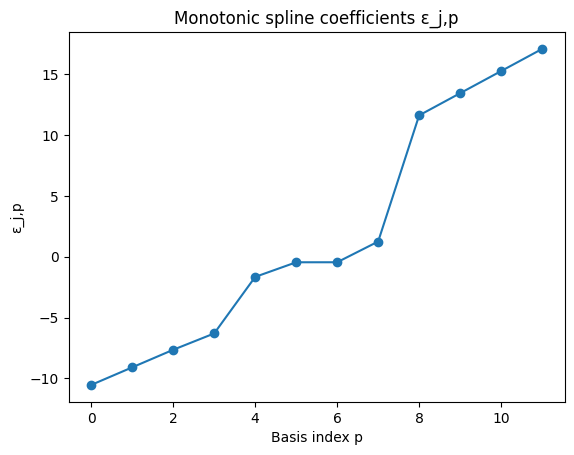

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8220, -8.1688, -6.3581, -4.7004, -3.0432, -1.3866,  0.2689,  1.9234,
         3.5759,  5.2283,  6.8807,  8.5331])


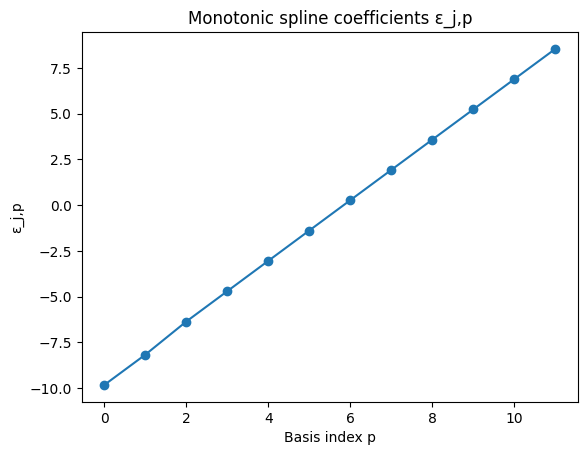

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.7878, -7.8266, -5.8654, -3.8396, -3.2459, -0.0295,  0.3512,  5.0111,
         6.8478,  8.6660, 10.4841, 12.3023])


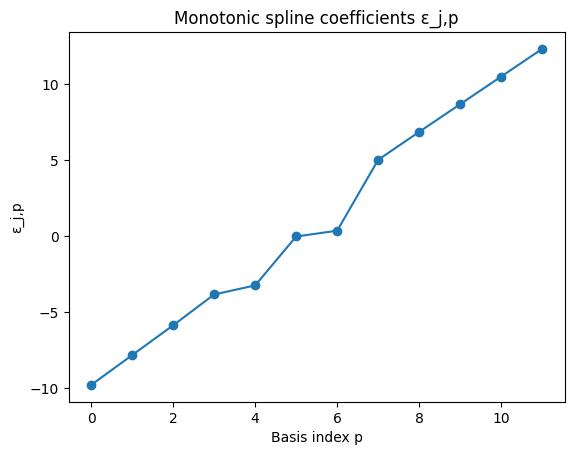

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8066, -8.1493, -6.2207, -4.5611, -2.9033, -1.2458,  0.4089,  2.0617,
         3.7141,  5.3665,  7.0189,  8.6712])


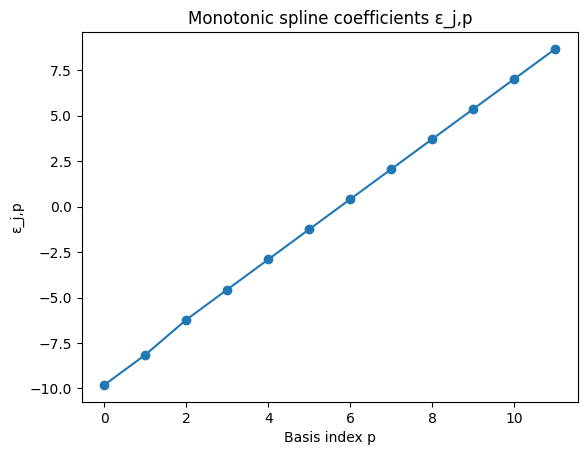

In [ ]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

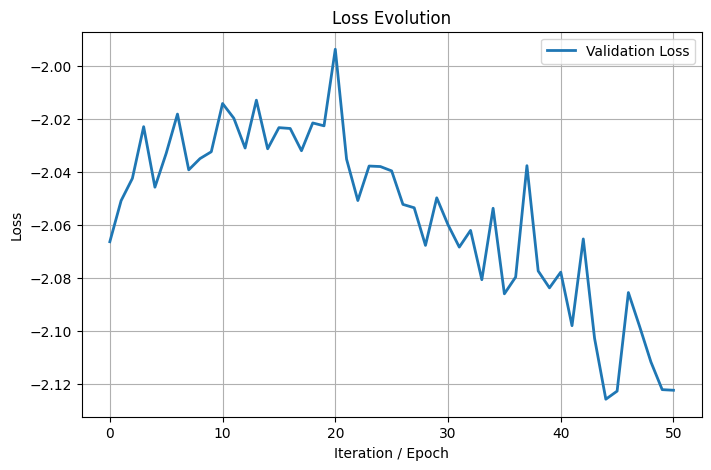

In [ ]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [39]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.9537
KLD GTM      Train Data:  0.058
KLD Gaussian Train Data:  -0.2605
KLD Copula   Train Data:  0.5252

KLD BGTM      Test  Data:  0.9812
KLD GTM      Test  Data:  0.0743
KLD Gaussian Test  Data:  -0.3061
KLD Copula   Test  Data:  0.5396


In [47]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

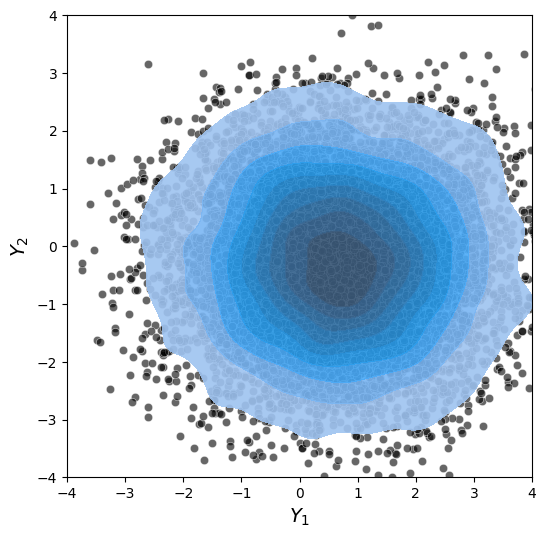

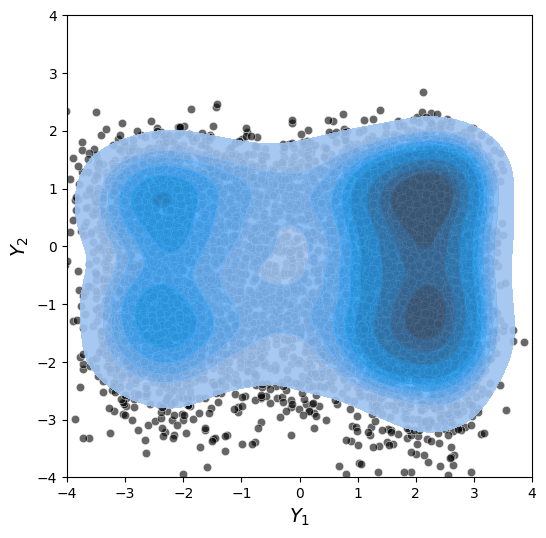

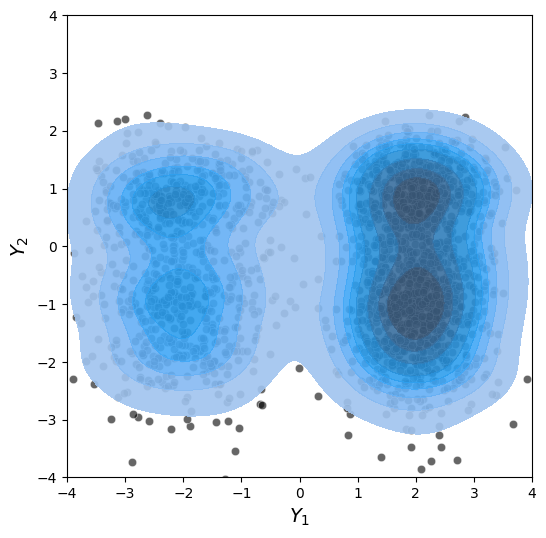

In [48]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])